1. Escriba un código que resuelva el problema del movimiento satelital mediante la ecuación de
Kepler, utilizando un método de busqueda de raices construido por usted mismo (no utilice
funciones provenientes de librerias importadas).

In [51]:
#Definición de variables
R_t=6378.137  #Radio de la tierra (km)
a=1.30262*R_t #semieje mayor en km
e=0.16561 #excentricidad
w=15 #grados, posición angular del pericentro
GM=398600.4405 #km^3/s^2
tp="2025-03-31 00:00:00"


#Tiempo especifico a calcular
t="2025-04-01 00:00:00"
#Posición para la cual se quiere el tiempo:
r0=1.5*R_t

In [52]:
from astropy.time import Time
from astropy.time import TimeDelta
import numpy as np

#Se crea una función que calcula f(t) para facilitar la función radial y angular
tp=Time(tp,format="iso",scale="utc")
def f(t):
    t=Time(t,format="iso",scale="utc")
    #Ecuación de Kepler
    def kepler(E,t):
        #Anomalía media:
        anomalia_media=np.sqrt(GM/a**3)*(t-tp).to_value('sec')#rad/s
        return E-e*np.sin(E)-anomalia_media

    # Método de las secantes como solución
    """
    Lo que se busca es el valor de E, por eso es la raiz buscada, 
    tal que para el tiempo que yo quiero dé cero la ecuación.

    """
    n_minus=0
    n=1e-5
    while np.abs(kepler(n,t))>1e-10:
        f_n=kepler(n,t)
        f_nminus=kepler(n_minus,t)
        n_plus=n-f_n*(n-n_minus)/(f_n-f_nminus)
        n_minus=n
        n=n_plus
        #Retorna E(t) en radianes como n

    #Se necesita la anomalia verdadera como f para r
    anomalia_verdadera=2*np.arctan(np.sqrt((1+e)/(1-e))*np.tan(n/2))
    return anomalia_verdadera


2. Incluya una función cuyo argumento es el tiempo de observación y retorna las coordenadas del satélite en ese instante.

        position(t)




In [53]:
def position(t):
    #Para la parte radial
    r=(a*(1-e**2))/(1+e*np.cos(f(t)))
    #Para la parte angular
    phi=np.degrees(f(t))+w
    #print(f'coordenada radial en km y angular en grados del satélite para el tiempo {t}')
    return float(r),float(phi)

position(t)

(9658.322106272506, 185.57050376292173)

3. Incluya una función sin argumentos de entrada y que retorna un gráfico con la orbita del satelite a lo largo de un
periodo completo.

        orbit()

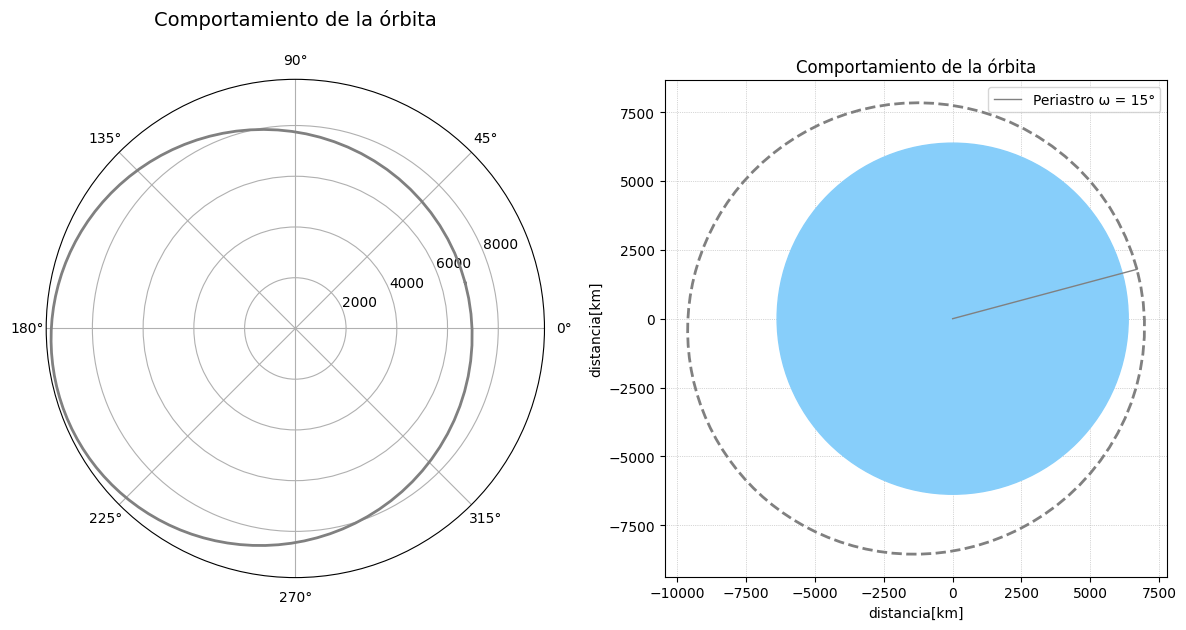

In [54]:
import matplotlib.pyplot as plt
"""
Se calcula el periodo con la ley de kepler, asumiendo la masa del satelite despreciable respecto a la de la tierra
"""

def orbit():
    T=2*np.pi*np.sqrt(a**3/GM)#en segundos
    Tiempos=tp+(TimeDelta(np.linspace(0,T,100), format="sec"))#en UTC
    resultados = np.array([position(t) for t in Tiempos])
    
    posiciones_radiales=resultados[:,0]
    posiciones_angulares=np.radians(resultados[:,1])
    pos_x=posiciones_radiales*np.cos(posiciones_angulares)
    pos_y=posiciones_radiales*np.sin(posiciones_angulares)

    fig = plt.figure(figsize=(12, 6))

    #Gráfico polar
    ax1 = fig.add_subplot(1, 2, 1, polar=True)
    ax1.plot(posiciones_angulares, posiciones_radiales, color='gray', linestyle='-', linewidth=2)
    ax1.set_title("Comportamiento de la órbita",fontsize=14, pad=20)

    #Gráfico en Cartesianas
    Tierra = plt.Circle((0, 0), radius=R_t, color='lightskyblue', zorder=5)

    # Posición del periastro (distancia mínima al foco)
    r_peri=a*(1-e)
    peri_x=r_peri*np.cos(np.radians(w))
    peri_y=r_peri*np.sin(np.radians(w))

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.add_patch(Tierra)
    ax2.plot(pos_x, pos_y,color='gray', linestyle='--', linewidth=2)
    ax2.plot([0, peri_x], [0, peri_y], '-',color="gray", linewidth=1, label='Periastro ω = 15°',zorder=10)
    ax2.set_aspect('equal') 
    ax2.set_title("Comportamiento de la órbita")
    ax2.set_xlabel("distancia[km]")
    ax2.set_ylabel("distancia[km]")
    ax2.grid(True, linestyle=':', linewidth=0.5)
    ax2.legend()

    plt.tight_layout()
    plt.show()
    
orbit()

4. Incluya una función cuyo argumento es un valor para la posición radial del satélite, r0. En caso de que esta posición pueda ser alcanzada por el satélite en su movimiento orbital, la función retorna el tiempo t0 en
el que el satélite se localiza allí.

        date(r0)

In [55]:
import astropy.units as u
def date(r0):
    """
    A nivel de cálculo es mucho mas rápido realizar el proceso inverso
    """
    #Obtener el f a partir de r0
    f=np.arccos((a/(e*r0)*(1-e**2))-1/e)
    #obtener E a partir de f
    E=2*np.arctan(np.sqrt((1-e)/(1+e))*np.tan(f/2))
    #obtener el l a partir del E
    l=E-e*np.sin(E)
    #obtener el t con el l
    t=(l*np.sqrt(a**3/GM))*u.s +tp

    return t.iso

date(r0)

'2025-03-31 00:53:09.883'